# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import fluids 

plt.rcParams['text.usetex'] = True

In [2]:
def impeller_reynold_number(stirring_speed, diameter_of_impeller, fluid_density, fluid_viscosity):
    return fluid_density * stirring_speed * diameter_of_impeller **2 / fluid_viscosity

#$ Important Constants
SPECIFIC_HEAT_CAPACITY_OF_WATER = 4182 #kJ/(kg ˚C)
VISCOSITY_OF_WATER_20C = 1e-3
DENSITY_OF_WATER_20C = 1e3
MOLECULAR_WEIGHT_OF_GLUCOUSE = 180
ENERGY_EVOLVED_FROM_CONSUPMTIION_OF_1MOL_OF_GLUCOSE = 1554 #kJ/mol


##Initial Conditions
INITIAL_YEAST_CONC = 1e7 # cells/mL (10 millions cel/mL)
WEIGHT_OF_A_YEAST_CELL = 1e-10 #g/cell
SYSTEM_VOLUME = 5 # L
SPECIFIC_YIELD_COEFFICIENT = 0.5

INTITAL_REACTOR_TEMPERATURE = 15
AMBIENT_TEMPERATURE = 20
INITIAL_GLUCOSE_IN_GRAMS = 50
STIRRING_SPEED = 300
IMPELLER_DIAMETER = 70e-3

# Part 1: Determination of Heat Loss Characteristics (Temperature Differential, Stirring)
Energy Balance with stirring (w/o aeration and reaction)

$$m C_v \frac{dT}{dt} = hS(T_{ext} - T) + N_p \rho N^3 d_A^5$$

From the first set of experiments conducted, we are able to obtained the overall heat loss coefficient, $h$, from the following equation (Refer to Cristian's document or Annex __ in the Main Report):
$$\Delta T = -\frac{N_p \rho N^3 d_A^5}{hS} + \bigg(\Delta T_0 + \frac{N_p \rho N^3 d_A^5}{hS} \bigg)\exp \bigg(-\frac{hS}{mC_v} t\bigg)$$ 

where $N_p$ is the drag coefficient of the mobile stirrer, $\rho$ is the mass density of the fluid, $N$ is the stirring speed (rpm), $d_A$ is the stirrer diameter, $S$ is the heat transfer area, $m$ is the mass of the fluid, $C_v$ is the heat capacity of fluid.

Using `scipy.optimize.curvefit`, it is possible to fit the experimental data with a exponential curve of the form :
$$\Delta T = -A + B e^{-C t}$$
where $A = \frac{N_p \rho N^3 d_A^5}{hS}$, $B = \Delta T_0 + \frac{N_p \rho N^3 d_A^5}{hS}$ and $C = \frac{hS}{mC_v}$

In [3]:
# Loading of experimental data for the first set of experiment
expt1 = pd.read_csv("expt1.csv")
expt1["delta_T"] = expt1["T_reactor"] - expt1["T_ambient"]
expt1.head()

Time  T_ambient  T_reactor  delta_T
0     0       21.9       56.2     34.3
1     5       21.8       55.5     33.7
2    10       21.3       54.8     33.5
3    15       21.0       54.3     33.3
4    20       21.9       53.4     31.5

/Users/tsoiwaimun/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


A =  0.7330202259049987
B =  35.593656052932616
C =  0.004274140309639933


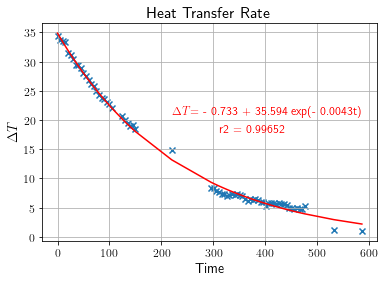

R^2 = 0.9965183216657246
Calculation of Parameters using Experimental Data
Impeller Reynold number =  1470000.0000000002
hS_air [W/K] =  89372.27387457101
Since the impeller reynold number is in the turbluent regime at 300 rpm stirring speed, where the power number remains constant, the power number for this experimental set-up is
Np_expt =  1.4436595947716104


In [4]:
def func(t, A, B, C):
    return -A + B * np.exp(-C * t)

delta_T = expt1["delta_T"]
time = expt1["Time"]
plt.scatter(time, delta_T, marker = "x")


popt, pcov = curve_fit(func, time, delta_T)
A, B, C = popt
print("A = ", A)
print("B = ", B)
print("C = ", C)

delta_T_fitted = func(time, *popt)
fitted_equation = (r"$\Delta T$" + "= -{0:9.3f} + {1:9.3f} exp(-{2:9.4f}t)".format(A, B, C))
r2 = r2_score(delta_T_fitted, delta_T)

plt.plot(time, delta_T_fitted, '-r')
plt.ylabel(r'$\Delta T$', fontsize=14)
plt.xlabel("Time", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.text(220, 21,s=fitted_equation, color ="r", fontsize= 12, fontweight="bold")
plt.text(310, 18, "r2 = {0:9.5f}".format(r2), color="r",fontsize= 12, fontweight="bold")
plt.title("Heat Transfer Rate", fontsize= 16)
plt.show()
print("R^2 =", r2)

# Calculation of parameters using Experimental Data
print("Calculation of Parameters using Experimental Data")
print("Impeller Reynold number = ", impeller_reynold_number(STIRRING_SPEED, IMPELLER_DIAMETER, DENSITY_OF_WATER_20C, VISCOSITY_OF_WATER_20C))

hS_air = C * SYSTEM_VOLUME * DENSITY_OF_WATER_20C * SPECIFIC_HEAT_CAPACITY_OF_WATER
print("hS_air [W/K] = ", hS_air)

print("Since the impeller reynold number is in the turbluent regime at 300 rpm stirring speed, where the power number remains constant, the power number for this experimental set-up is")
power_number = A * hS_air/(STIRRING_SPEED ** 3 * DENSITY_OF_WATER_20C * IMPELLER_DIAMETER ** 5)
print("Np_expt = ", power_number)

## Experiment 4 : Determination of heat loss characters with a fully filled jacket
This experiment is conducted with water at 15˚C (no circulation) in the double jacket

In [5]:
# Loading of experimental data for the first set of experiment
expt4 = pd.read_csv("expt4.csv")
expt4["delta_T"] = expt4["T_reactor"] - expt4["T_ambient"]
expt4.head()

Time  T_ambient  T_reactor  delta_T
0     0         21       25.1      4.1
1    15         21       24.9      3.9
2    20         21       24.7      3.7
3   223         21       23.1      2.1
4   282         21       23.0      2.0

A =  -1.7325818375446145
B =  2.377942488406203
C =  0.00814710597686131


/Users/tsoiwaimun/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


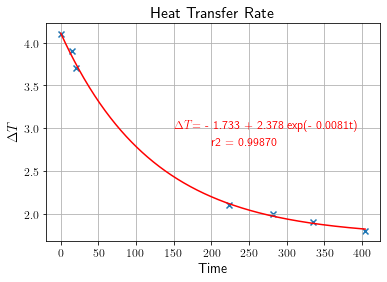

R^2 = 0.9986968105996353
Calculation of Parameters using Experimental Data
Impeller Reynold number =  1470000.0000000002
hS_water [W/K] =  170355.98597617


In [6]:
def func(t, A, B, C):
    return -A + B * np.exp(-C * t)

delta_T = expt4["delta_T"]
time = expt4["Time"]
plt.scatter(time, delta_T, marker = "x")


popt, pcov = curve_fit(func, time, delta_T)
A, B, C = popt
print("A = ", A)
print("B = ", B)
print("C = ", C)

delta_T_fitted = func(time, *popt)
fitted_equation = (r"$\Delta T$" + "= -{0:9.3f} + {1:9.3f} exp(-{2:9.4f}t)".format(abs(A), B, C))
r2 = r2_score(delta_T_fitted, delta_T)

time_space = np.array([i for i in range(0,405)])
delta_T_space = func(time_space, *popt)


plt.plot(time_space, delta_T_space, '-r')
plt.ylabel(r'$\Delta T$', fontsize=14)
plt.xlabel("Time", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.text(150, 3,s=fitted_equation, color ="r", fontsize= 12, fontweight="bold")
plt.text(200, 2.8, "r2 = {0:9.5f}".format(r2), color="r",fontsize= 12, fontweight="bold")
plt.title("Heat Transfer Rate", fontsize= 16)
plt.show()
print("R^2 =", r2)

# Calculation of parameters using Experimental Data
print("Calculation of Parameters using Experimental Data")
print("Impeller Reynold number = ", impeller_reynold_number(STIRRING_SPEED, IMPELLER_DIAMETER, DENSITY_OF_WATER_20C, VISCOSITY_OF_WATER_20C))

hS_water = C * SYSTEM_VOLUME * DENSITY_OF_WATER_20C * SPECIFIC_HEAT_CAPACITY_OF_WATER
print("hS_water [W/K] = ", hS_water)

# Part 2: Cell Growth Model

Assuming that the yeast growth follows the Monod's model, with parameters $\mu_{max}$, the maximum growth rate and $K_s$ is the "half-velocity" constant. The doubling time, $t_D$ can be obtained:

$$t_D (T) = \frac{\ln(2)}{\mu(T)} $$


The cell growth model can be described by a first-order differential equation:

$$ \frac{dX}{dt} = \mu(T) X$$

where X is the number of micro-organisms.
To obtain the time evolution of micro-organisms,
$$ \int^{X(t)}_{X_0} \frac{1}{X(t)} dX  = \int^{t}_{0} \mu (T) \  dt \implies \ln \bigg(\frac{X(t)}{X_0}\bigg) = \mu t \implies X(t) = X_0 e^{\frac{\ln(2)}{t_D (T)}t}$$

Since the $\mu$ is dependent on temperature, the maximum growth rate, $\mu_{max}$, 

$$ \mu_{max} = \frac{A\exp{(-E_g/RT)}}{1+ B\exp{(-\Delta G_d}/RT)}$$
where A, B are pre-exponential constants, $E_g$ is the activation energy [kJ/mol] of the growth process and $\Delta G_d$ is free energy change of protein denaturation [kJ/mol]. From [2], these values are found to be

| A | B | $E_g$ (kJ/mol)| $\Delta G_d$ (kJ/mol)|
|:--:|:--:|:-:|:--:|
| $8.9877 \times 10^{18}$ | $5.8935 \times 10^{50}$ | 111990 | 296900 | 

References

1. [Cell size and morphological properties of yeast Saccharomyces cerevisiae in relation to growth temperature](https://pubmed.ncbi.nlm.nih.gov/29718340/
)
2. [Metabolic efficiency in yeast Saccharomyces cerevisiae in relation to temperature dependent growth and biomass yield](https://pubmed.ncbi.nlm.nih.gov/26267506/)


In [7]:
# A = 8.9877e18
# B = 5.8935e50
# Eg = 111990
# Delta_Gd = 296900
# R = 8.314

# def get_max_specific_growth_rate(A, B, Eg, Delta_Gd, T_indegC): #units = 1/ h
#   T_inK = T_indegC + 273.15
#   return (A * np.exp(-Eg/ (R * T_inK))) / (1 + B * np.exp(-Delta_Gd/ (R*T_inK))) 


# def get_doubling_time(A, B, Eg, Delta_Gd, T_indegC): #units = mins
#   return 1/ get_max_specific_growth_rate(A, B, Eg, Delta_Gd, T_indegC) * 60

# print(get_max_specific_growth_rate(A, B, Eg, Delta_Gd, 20))
# print(get_doubling_time(A, B, Eg, Delta_Gd, 20))

# T_data = np.linspace(0, 40, num= 800+1).tolist()
# mu_data = [get_max_specific_growth_rate(A, B, Eg, Delta_Gd, T) for T in T_data]
# tD_data = [1/ mu * 60 for mu in mu_data]
# # print(T_data)
# print(max(mu_data))
# print(T_data[mu_data.index(max(mu_data))])
# plt.plot(T_data, tD_data)

def cell_growth(doubling_time, current_yeast_conc, time_interval_in_mins):
  return current_yeast_conc * np.exp (np.log(2) / doubling_time * time_interval_in_mins)

# INITIAL_YEAST_CONC = 1e7 # cells/L
# cell_data = [INITIAL_YEAST_CONC]

# for i in range(len(time_data) - 1):
#   curr_T = temp_data[i]
#   cell_data.append(cell_growth(get_doubling_time(A, B, Eg, Delta_Gd, curr_T), cell_data[i], time_data[i+1] - time_data[i]))

# plt.plot(time_data, cell_data)

# Simulation
## Energy Balance with Exothermic Reaction
Combining the cell growth model with the heat loss model, we obtain the following energy balance equation
$$m C_v \frac{dT}{dt} = hS(T_{ext} - T) + N_p \rho N^3 d_A^5 +\dot{q}_{rxn}$$

The $\dot{q}_{rxn}$ can be determined from the amount of glucose consumed with each time interval, $\Delta t$

$$\dot{q}_{rxn} = \frac{C_{cell}(t + \Delta t) - C_{cell}(t)}{\gamma} \times \frac{\Delta H_{glc}}{MW_{glc}}$$ 

where $\Delta H_{glc}$ = 1554 kJ/mol and $MW_{glc} = 180 g/mol$, $C_{cell}$ is the dry weight cell concentration with respect to the system volume [g/5L] and $\gamma$ is the specific yield coefficient in $\frac{g \ cell}{g \ glc}$

Using $C_{cell} (t+\Delta t) = C_{cell}(t) e^{\frac{\ln (2)}{t_D(T)} \Delta t}$, 

$$\dot{q}_{rxn} = \frac{C_{cell}(t) \big( e^{\frac{\ln (2)}{t_D(T)} \Delta t} - 1\big)}{\gamma} \times \frac{\Delta H_{glc}}{MW_{glc}}$$ 

Therefore, the energy balance equation can be written as
$$\frac{dT}{dt} = \frac{hS}{m C_v}(T_{ext} - T) + \frac{N_p \rho N^3 d_A^5}{m C_v} +\frac{C_{cell}(t) \big( e^{\frac{\ln (2)}{t_D(T)} \Delta t} - 1\big)}{\gamma} \times \frac{\Delta H_{glc}}{MW_{glc} m C_v}$$

In [8]:
#$ Important Constants
SPECIFIC_HEAT_CAPACITY_OF_WATER = 4182 #kJ/(kg ˚C)
VISCOSITY_OF_WATER_20C = 1e-3
DENSITY_OF_WATER_20C = 1e3
MOLECULAR_WEIGHT_OF_GLUCOUSE = 180
ENERGY_EVOLVED_FROM_CONSUPMTIION_OF_1MOL_OF_GLUCOSE = 1554 #kJ/mol


##Initial Conditions
INITIAL_YEAST_CONC = 1e7 # cells/mL (10 millions cel/mL)
WEIGHT_OF_A_YEAST_CELL = 1e-10 #g/cell
SYSTEM_VOLUME = 5 # L
SPECIFIC_YIELD_COEFFICIENT = 0.5
DOUBLING_TIME = 150 #mins

INTITAL_REACTOR_TEMPERATURE = 15
AMBIENT_TEMPERATURE = 20
INITIAL_GLUCOSE_IN_GRAMS = 50
STIRRING_SPEED = 300
IMPELLER_DIAMETER = 70e-3

In [9]:
def yeast_conc_from_numberOfCellesPerLiter_to_dryweightGramsPerSystemVolume(system_volumeinLiters ,numberOfCellesPerMilliLiter):
  return numberOfCellesPerMilliLiter * 1e3 * WEIGHT_OF_A_YEAST_CELL * system_volumeinLiters

def yeast_conc_to_numberOfCellesPerLiter_from_dryweightGramsPerSystemVolume(system_volumeinLiters ,dryweightGramsPerSystemVolume):
  return  dryweightGramsPerSystemVolume / system_volumeinLiters / WEIGHT_OF_A_YEAST_CELL / 1e3

def amount_of_glucose_used_in_gramsPerSystemVolume(specific_yield_constant, initial_yeast_conc_in_gPerSystemVolume, next_yeast_conc_in_gPerSystemVolume):
  return (next_yeast_conc_in_gPerSystemVolume - initial_yeast_conc_in_gPerSystemVolume) / specific_yield_constant

def heat_evolved_by_glucose_reaction(amount_of_glucose_used_in_gramsPerSystemVolume):
  ENERGY_EVOLVED_FROM_CONSUPMTIION_OF_1G_OF_GLUCOSE = ENERGY_EVOLVED_FROM_CONSUPMTIION_OF_1MOL_OF_GLUCOSE / SPECIFIC_HEAT_CAPACITY_OF_WATER / MOLECULAR_WEIGHT_OF_GLUCOUSE * 1e3 #kcal/g
  return amount_of_glucose_used_in_gramsPerSystemVolume * ENERGY_EVOLVED_FROM_CONSUPMTIION_OF_1G_OF_GLUCOSE #kcal / 5L

## Model Ver with threshold Temp

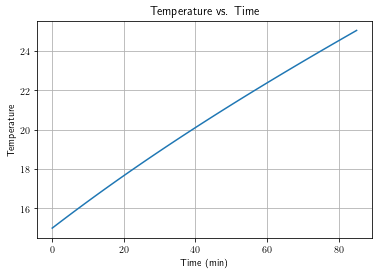

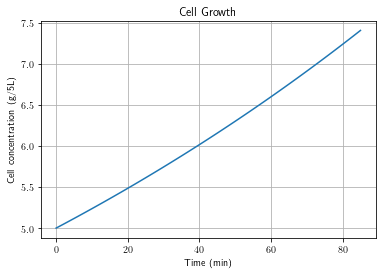

----------------------------------------------
End Time =  85 mins
Final Temperature (˚C) =  25.04737433033119
Final Cell Concentration (g/5L) = 7.405487761432851
Final Cell Concentration (cell/ml) = 14810975.522865701
Amount of glc used (g) =  4.810975522865702


In [10]:
# Start of Simulation (Temperature Limited)
TIME_INTERVAL = 1 # min
FINAL_TIME = 1000 
THRESHOLD_TEMPERATURE = 25

time_data = []
temperature_data = []
cell_data = []
glucose_data = []
used_glucose_data = []

curr_time = 0
curr_T = INTITAL_REACTOR_TEMPERATURE
curr_cell_conc = yeast_conc_from_numberOfCellesPerLiter_to_dryweightGramsPerSystemVolume(SYSTEM_VOLUME, INITIAL_YEAST_CONC)
curr_glucose = INITIAL_GLUCOSE_IN_GRAMS

time_data.append(curr_time)
temperature_data.append(curr_T)
cell_data.append(curr_cell_conc)
glucose_data.append(curr_glucose)

while curr_T < THRESHOLD_TEMPERATURE:
    next_cell_conc = cell_growth(DOUBLING_TIME, curr_cell_conc, TIME_INTERVAL)

    amount_glc_needed = amount_of_glucose_used_in_gramsPerSystemVolume(SPECIFIC_YIELD_COEFFICIENT, curr_cell_conc, next_cell_conc)
    curr_time += TIME_INTERVAL
    curr_T = curr_T + heat_evolved_by_glucose_reaction(amount_glc_needed) + hS_water / (SYSTEM_VOLUME* DENSITY_OF_WATER_20C * SPECIFIC_HEAT_CAPACITY_OF_WATER) * (AMBIENT_TEMPERATURE-curr_T) + power_number * DENSITY_OF_WATER_20C * STIRRING_SPEED ** 3 * IMPELLER_DIAMETER ** 5 / (SYSTEM_VOLUME * DENSITY_OF_WATER_20C * SPECIFIC_HEAT_CAPACITY_OF_WATER)
    curr_cell_conc = next_cell_conc
    curr_glucose -= amount_glc_needed
    time_data.append(curr_time)
    temperature_data.append(curr_T)
    cell_data.append(curr_cell_conc)
    glucose_data.append(curr_glucose)
    used_glucose_data.append(amount_glc_needed)

plt.title("Temperature vs. Time")
plt.xlabel("Time (min)")
plt.ylabel("Temperature")
plt.grid()
plt.plot(time_data, temperature_data)
plt.show()

plt.title("Cell Growth")
plt.ylabel("Cell concentration (g/5L)")
plt.xlabel("Time (min)")
plt.grid()
plt.plot(time_data, cell_data)
plt.show()


print("----------------------------------------------")
print("End Time = ", time_data[-1], "mins")
print("Final Temperature (˚C) = ", temperature_data[-1])
print("Final Cell Concentration (g/5L) =", cell_data[-1])
print("Final Cell Concentration (cell/ml) =", yeast_conc_to_numberOfCellesPerLiter_from_dryweightGramsPerSystemVolume(SYSTEM_VOLUME,cell_data[-1]))
print("Amount of glc used (g) = ", sum(used_glucose_data))


## Model termninates with Time

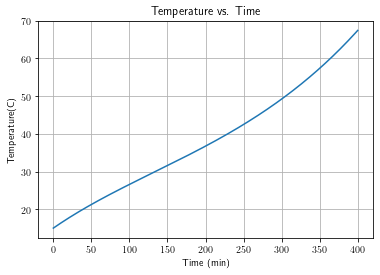

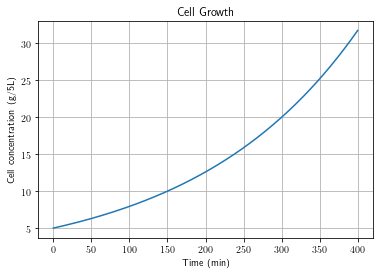

----------------------------------------------
End Time =  400
Final Temperature (˚C) =  67.40711532919136
Final Cell Concentration (g/5L) = 31.748021039364545
Final Cell Concentration (cell/ml) = 63496042.078729086
Amount of glc used =  53.49604207872909


In [11]:
# Start of Simulation (Temperature Limited)
TIME_INTERVAL = 1 # min
FINAL_TIME = 400 

time_data = []
temperature_data = []
cell_data = []
glucose_data = []
used_glucose_data = []

curr_time = 0
curr_T = INTITAL_REACTOR_TEMPERATURE
curr_cell_conc = yeast_conc_from_numberOfCellesPerLiter_to_dryweightGramsPerSystemVolume(SYSTEM_VOLUME, INITIAL_YEAST_CONC)
curr_glucose = INITIAL_GLUCOSE_IN_GRAMS

time_data.append(curr_time)
temperature_data.append(curr_T)
cell_data.append(curr_cell_conc)
glucose_data.append(curr_glucose)

while curr_time < FINAL_TIME:
    next_cell_conc = cell_growth(DOUBLING_TIME, curr_cell_conc, TIME_INTERVAL)

    amount_glc_needed = amount_of_glucose_used_in_gramsPerSystemVolume(SPECIFIC_YIELD_COEFFICIENT, curr_cell_conc, next_cell_conc)
    curr_time += TIME_INTERVAL
    # print(hS)
    # print(power_number)
    # print(hS / (SYSTEM_VOLUME* DENSITY_OF_WATER_20C * SPECIFIC_HEAT_CAPACITY_OF_WATER) * (AMBIENT_TEMPERATURE-curr_T))
    # print(power_number * DENSITY_OF_WATER_20C * STIRRING_SPEED ** 3 * IMPELLER_DIAMETER ** 5 / (SYSTEM_VOLUME * DENSITY_OF_WATER_20C * SPECIFIC_HEAT_CAPACITY_OF_WATER))
    # print(heat_evolved_by_glucose_reaction(amount_glc_needed))
    curr_T = curr_T + heat_evolved_by_glucose_reaction(amount_glc_needed) + hS_water / (SYSTEM_VOLUME* DENSITY_OF_WATER_20C * SPECIFIC_HEAT_CAPACITY_OF_WATER) * (AMBIENT_TEMPERATURE-curr_T) + power_number * DENSITY_OF_WATER_20C * STIRRING_SPEED ** 3 * IMPELLER_DIAMETER ** 5 / (SYSTEM_VOLUME * DENSITY_OF_WATER_20C * SPECIFIC_HEAT_CAPACITY_OF_WATER)
    curr_cell_conc = next_cell_conc
    curr_glucose -= amount_glc_needed
    time_data.append(curr_time)
    temperature_data.append(curr_T)
    cell_data.append(curr_cell_conc)
    glucose_data.append(curr_glucose)
    used_glucose_data.append(amount_glc_needed)
    
    # print(curr_time,curr_T,curr_cell_conc, amount_glc_needed)


# print(curr_time,curr_T,curr_cell_conc, amount_glc_needed)

plt.title("Temperature vs. Time")
plt.xlabel("Time (min)")
plt.ylabel("Temperature(C)")
plt.grid()
plt.plot(time_data, temperature_data)
plt.show()

plt.title("Cell Growth")
plt.ylabel("Cell concentration (g/5L)")
plt.xlabel("Time (min)")
plt.grid()
plt.plot(time_data, cell_data)
plt.show()

print("----------------------------------------------")
print("End Time = ", time_data[-1])
print("Final Temperature (˚C) = ", temperature_data[-1])
print("Final Cell Concentration (g/5L) =", cell_data[-1])
print("Final Cell Concentration (cell/ml) =", yeast_conc_to_numberOfCellesPerLiter_from_dryweightGramsPerSystemVolume(SYSTEM_VOLUME,cell_data[-1]))
print("Amount of glc used = ", sum(used_glucose_data))

## Counterbalancing Heat Loss due to Temperature Differential with Stirring

$$N = \bigg[\frac{hS(T-T_{ext})}{N_p \rho d_A^5}\bigg]^{\frac{!}{3}}$$

/var/folders/2g/cn9xxr911db7d9jzqqjhzdn40000gn/T/ipykernel_99729/4145159367.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (hS * (T-T_ambient) / (power_number * density * impeller_diameter ** 5)) ** (1/3)


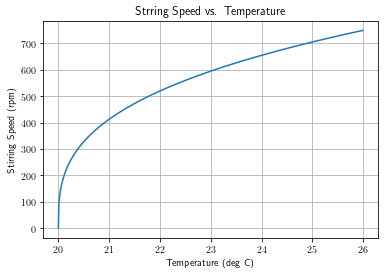

In [12]:
def N_equilibrium(hS, T, T_ambient, power_number, density, impeller_diameter):
    return (hS * (T-T_ambient) / (power_number * density * impeller_diameter ** 5)) ** (1/3)

temperatue_space = [i/100 for i in range(1500,2600)]
N_space = [N_equilibrium(hS=hS_water, T=T, T_ambient=AMBIENT_TEMPERATURE, power_number=power_number, density=DENSITY_OF_WATER_20C,impeller_diameter=IMPELLER_DIAMETER) for T in temperatue_space]

plt.plot(temperatue_space, N_space)
plt.title("Strring Speed vs. Temperature")
plt.xlabel("Temperature (deg C)")
plt.ylabel("Stirring Speed (rpm)")
plt.grid()